In [3]:
import pickle
import sys

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)
my_cmap = ListedColormap(sns.diverging_palette(220, 20, n=256).as_hex())

sys.path.append('../src')
import analyze
import raybay

In [4]:
grid = np.load('SBRT_lung_minsun/grid/res_grid.pkl', allow_pickle=True)
dummy = np.load('SBRT_lung_minsun/grid/res_lin_dummy_minimize.pkl', allow_pickle=True)
bayes_lin = np.load('SBRT_lung_minsun/grid/res_lin_gp_minimize.pkl', allow_pickle=True)

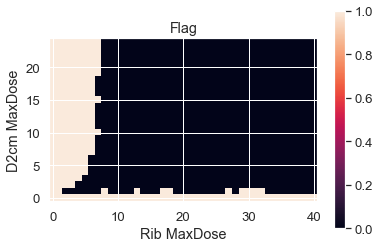

In [5]:
# Flags vs. parameters (0 = good, 1 = RayStation unable to normalize to PTV D95)
d2cm = np.arange(0, 2500, 100)
rib = np.arange(0, 4100, 100)
Z_flag = np.zeros((len(rib), len(d2cm)))
k = 0
for ii in range(len(d2cm)):
    for jj in range(len(rib)):
        Z_flag[jj, ii] = grid.flag_list[k]
        k += 1
plt.imshow(Z_flag.T, origin='lower')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Flag')
plt.colorbar();

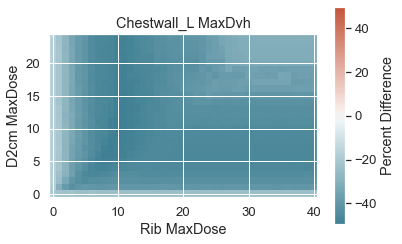

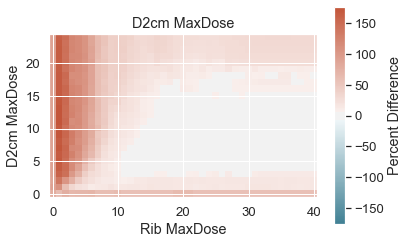

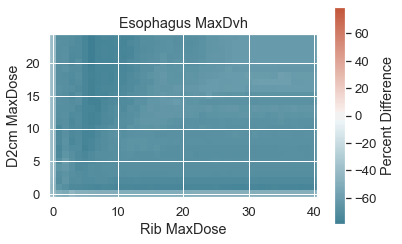

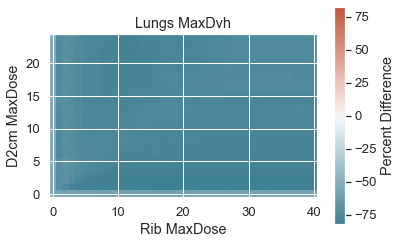

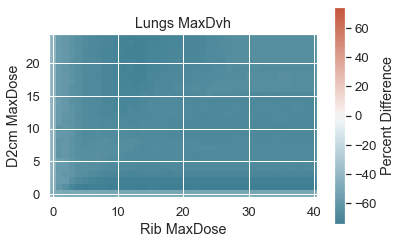

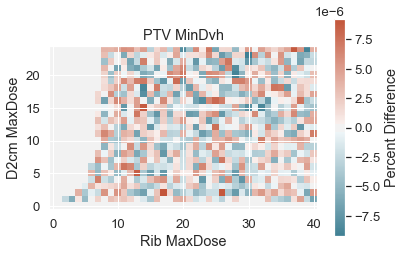

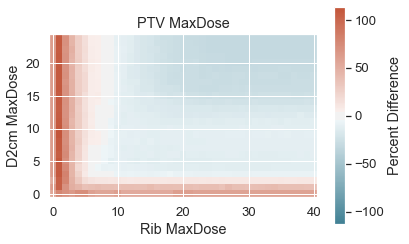

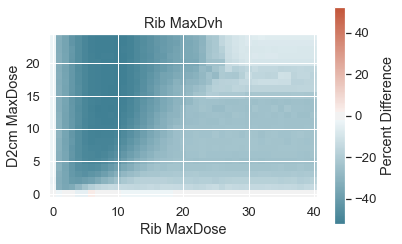

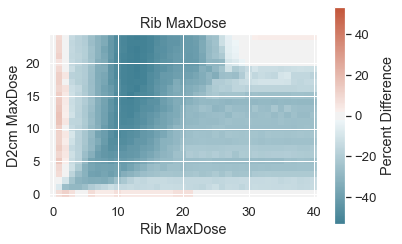

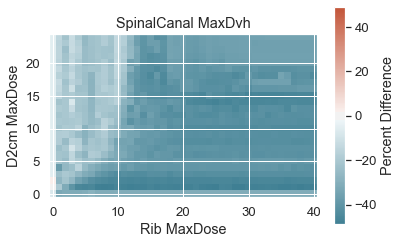

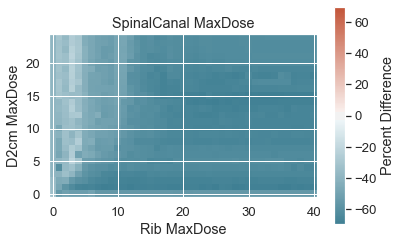

In [6]:
# Goal values vs. parameters (relative values)
for goal in grid.goal_dict:
    Z_goals = np.zeros_like(Z_flag)
    k = 0
    for ii in range(len(d2cm)):
        for jj in range(len(rib)):
            level = grid.goal_df.iloc[goal]['AcceptanceLevel']
            Z_goals[jj, ii] = 100*(grid.goal_dict[goal][k] - level)/level
            k += 1
    plt.figure()
    gval = np.max(np.abs(Z_goals))
    plt.imshow(Z_goals.T, origin='lower', cmap=my_cmap, vmin=-gval, vmax=gval)
    plt.xlabel('Rib MaxDose')
    plt.ylabel('D2cm MaxDose')
    plt.title(f"{grid.goal_df.iloc[goal]['Roi']} {grid.goal_df.iloc[goal]['Type']}")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Percent Difference')

Grid Max Utility 467.58, Rib: 14, D2cm: 17


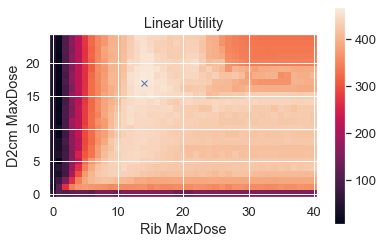

In [59]:
# Linear utility vs. parameters
Z_lin = np.zeros_like(Z_flag)
k = 0
val = 0
valk = 0
for ii in range(len(d2cm)):
    for jj in range(len(rib)):
        for index, row in grid.goal_df.iterrows():
            Z_lin[jj, ii] += raybay.get_term(grid.goal_dict[index][k], row['AcceptanceLevel'], row['Type'], 'linear')
        if val < Z_lin[jj,ii]:
            val = Z_lin[jj,ii]
            valk = k
        k += 1
plt.imshow(Z_lin.T, origin='lower')
idx_lin = np.unravel_index(np.argmax(Z_lin), Z_lin.shape)
plt.plot(idx_lin[0], idx_lin[1], 'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear Utility')
plt.colorbar()

print(f'Grid Max Utility {np.max(Z_lin):.2f}, Rib: {idx_lin[0]}, D2cm: {idx_lin[1]}')

Grid Max Utility 467.58, Rib: 14, D2cm: 17
Dummy Max Utility 451.00, Rib: 15.10, D2cm: 21.41


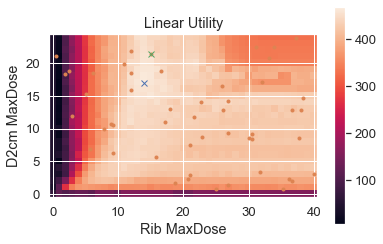

In [8]:
d2cm_dummy = [row[0]/100 for row in dummy.opt_result.x_iters]
rib_dummy = [row[1]/100 for row in dummy.opt_result.x_iters]

plt.imshow(Z_lin.T, origin='lower')
plt.plot(idx_lin[0], idx_lin[1], 'x')
plt.plot(rib_dummy, d2cm_dummy, '.')
plt.plot(dummy.opt_result.x[1]/100, dummy.opt_result.x[0]/100,'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear Utility')
plt.colorbar()

print(f'Grid Max Utility {np.max(Z_lin):.2f}, Rib: {idx_lin[0]}, D2cm: {idx_lin[1]}')
print(f'Dummy Max Utility {-dummy.opt_result.fun:.2f}, Rib: {dummy.opt_result.x[1]/100:.2f}, D2cm: {dummy.opt_result.x[0]/100:.2f}')

Grid Max Utility 467.58, Rib: 14, D2cm: 17
Dummy Max Utility 465.94, Rib: 15.25, D2cm: 18.42


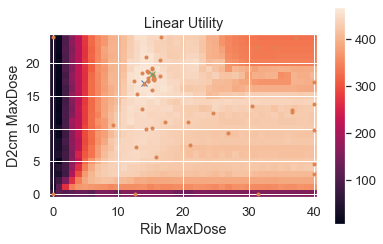

In [9]:
d2cm_lin = [row[0]/100 for row in bayes_lin.opt_result.x_iters]
rib_lin = [row[1]/100 for row in bayes_lin.opt_result.x_iters]

plt.imshow(Z_lin.T, origin='lower')
plt.plot(idx_lin[0], idx_lin[1], 'x')
plt.plot(rib_lin, d2cm_lin, '.')
plt.plot(bayes_lin.opt_result.x[1]/100, bayes_lin.opt_result.x[0]/100,'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear Utility')
plt.colorbar()

print(f'Grid Max Utility {np.max(Z_lin):.2f}, Rib: {idx_lin[0]}, D2cm: {idx_lin[1]}')
print(f'Dummy Max Utility {-bayes_lin.opt_result.fun:.2f}, Rib: {bayes_lin.opt_result.x[1]/100:.2f}, D2cm: {bayes_lin.opt_result.x[0]/100:.2f}')

Grid Max Utility 467.58, Rib: 14, D2cm: 17
Dummy Max Utility 451.00, Rib: 15.10, D2cm: 21.41
Dummy Max Utility 465.94, Rib: 15.25, D2cm: 18.42


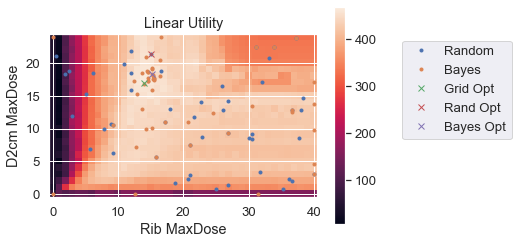

In [26]:
# Linear utility vs. parameters
plt.imshow(Z_lin.T, origin='lower')

plt.plot(rib_dummy, d2cm_dummy, '.')
plt.plot(rib_lin, d2cm_lin, '.')


plt.plot(idx_lin[0], idx_lin[1], 'x')
plt.plot(dummy.opt_result.x[1]/100, dummy.opt_result.x[0]/100,'x')
plt.plot(bayes_lin.opt_result.x[1]/100, bayes_lin.opt_result.x[0]/100,'x')

plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear Utility')
plt.colorbar()
plt.legend((['Random', 'Bayes', 'Grid Opt', 'Rand Opt', 'Bayes Opt']), bbox_to_anchor=(1.75, 1))

print(f'Grid Max Utility {np.max(Z_lin):.2f}, Rib: {idx_lin[0]}, D2cm: {idx_lin[1]}')
print(f'Dummy Max Utility {-dummy.opt_result.fun:.2f}, Rib: {dummy.opt_result.x[1]/100:.2f}, D2cm: {dummy.opt_result.x[0]/100:.2f}')
print(f'Dummy Max Utility {-bayes_lin.opt_result.fun:.2f}, Rib: {bayes_lin.opt_result.x[1]/100:.2f}, D2cm: {bayes_lin.opt_result.x[0]/100:.2f}')

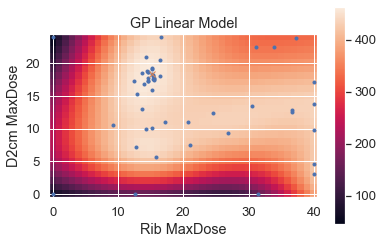

In [19]:
Z_lin_gp = np.zeros_like(Z_flag)
k = 0
for ii in range(len(d2cm)):
    for jj in range(len(rib)):
        Z_lin_gp[jj, ii] = -bayes_lin.opt_result.models[-1].predict(np.array([d2cm[ii]/2400,rib[jj]/4000]).reshape(1, -1))[0]
plt.imshow(Z_lin_gp.T, origin='lower')
plt.plot(rib_lin, d2cm_lin, '.')
plt.plot(bayes_lin.opt_result.x[1]/100, bayes_lin.opt_result.x[0]/100,'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('GP Linear Model')
plt.colorbar();

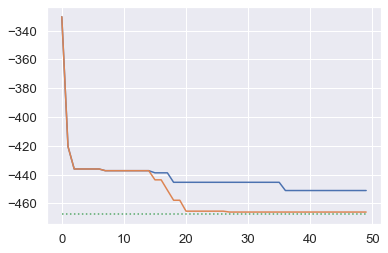

In [40]:
plt.plot(np.minimum.accumulate(dummy.opt_result.func_vals))
plt.plot(np.minimum.accumulate(bayes_lin.opt_result.func_vals))
plt.plot([0, 49], [-np.max(Z_lin), -np.max(Z_lin)], ':')

Grid Max Utility 445.13, Rib: 19, D2cm: 15


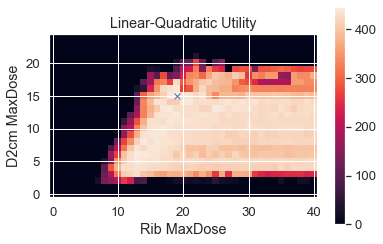

In [76]:
# Linear-quadratic utility vs. parameters
goals_linquad = pd.read_csv('SBRT_lung_minsun/grid/goals_linquad.csv')

Z_linquad = np.zeros_like(Z_flag)
k = 0
for ii in range(len(d2cm)):
    for jj in range(len(rib)):
        for index, row in goals_linquad.iterrows():
            Z_linquad[jj, ii] += row['Weight']*raybay.get_term(grid.goal_dict[index][k], row['AcceptanceLevel'], row['Type'], row['Shape'])
        k += 1
plt.imshow(Z_linquad.T, origin='lower')
idx_linquad = np.unravel_index(np.argmax(Z_linquad), Z_linquad.shape)
plt.plot(idx_linquad[0], idx_linquad[1], 'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear-Quadratic Utility')
plt.clim([0, np.max(Z_linquad)])
plt.colorbar()

print(f'Grid Max Utility {np.max(Z_linquad):.2f}, Rib: {idx_linquad[0]}, D2cm: {idx_linquad[1]}')

Grid Max Utility 445.13, Rib: 19, D2cm: 15
Dummy Max Utility 442.32, Rib: 22.64, D2cm: 14.03


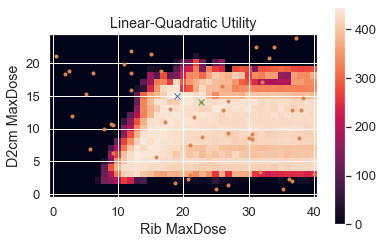

In [95]:
plt.imshow(Z_linquad.T, origin='lower')
plt.plot(idx_linquad[0], idx_linquad[1], 'x')

plt.plot(rib_dummy, d2cm_dummy, '.')
dummy_linquad = raybay.get_utility(goals_linquad, dummy.goal_dict)
idx_dummy = np.argmax(dummy_linquad)

plt.plot(dummy.opt_result.x_iters[idx_dummy][1]/100, dummy.opt_result.x_iters[idx_dummy][0]/100,'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear-Quadratic Utility')
plt.clim([0, np.max(Z_linquad)])
plt.colorbar()

print(f'Grid Max Utility {np.max(Z_linquad):.2f}, Rib: {idx_linquad[0]}, D2cm: {idx_linquad[1]}')
print(f'Dummy Max Utility {np.max(dummy_linquad):.2f}, Rib: {dummy.opt_result.x_iters[idx_dummy][1]/100:.2f}, D2cm: {dummy.opt_result.x_iters[idx_dummy][0]/100:.2f}')

In [91]:
bayes_linquad = np.load('SBRT_lung_minsun/grid/res_linquad_gp_minimize.pkl', allow_pickle=True)

Grid Max Utility 445.13, Rib: 19, D2cm: 15
Bayes Max Utility 442.98, Rib: 25.68, D2cm: 13.30


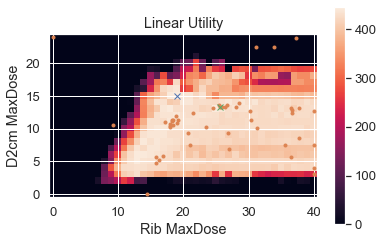

In [99]:
plt.imshow(Z_linquad.T, origin='lower')
plt.plot(idx_linquad[0], idx_linquad[1], 'x')

d2cm_linquad = [row[0]/100 for row in bayes_linquad.opt_result.x_iters]
rib_linquad = [row[1]/100 for row in bayes_linquad.opt_result.x_iters]
plt.plot(rib_linquad, d2cm_linquad, '.')

plt.plot(bayes_linquad.opt_result.x[1]/100, bayes_linquad.opt_result.x[0]/100,'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear Utility')
plt.clim([0, np.max(Z_linquad)])
plt.colorbar()

print(f'Grid Max Utility {np.max(Z_linquad):.2f}, Rib: {idx_linquad[0]}, D2cm: {idx_linquad[1]}')
print(f'Bayes Max Utility {-bayes_linquad.opt_result.fun:.2f}, Rib: {bayes_linquad.opt_result.x[1]/100:.2f}, D2cm: {bayes_linquad.opt_result.x[0]/100:.2f}')

Grid Max Utility 445.13, Rib: 19, D2cm: 15
Dummy Max Utility 442.32, Rib: 22.64, D2cm: 14.03
Bayes Max Utility 442.98, Rib: 25.68, D2cm: 13.30


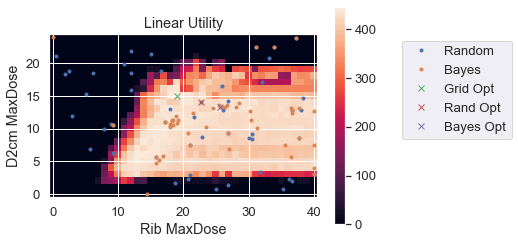

In [101]:
plt.imshow(Z_linquad.T, origin='lower')

plt.plot(rib_dummy, d2cm_dummy, '.')
plt.plot(rib_linquad, d2cm_linquad, '.')

plt.plot(idx_linquad[0], idx_linquad[1], 'x')
plt.plot(dummy.opt_result.x_iters[idx_dummy][1]/100, dummy.opt_result.x_iters[idx_dummy][0]/100,'x')
plt.plot(bayes_linquad.opt_result.x[1]/100, bayes_linquad.opt_result.x[0]/100,'x')

plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('Linear Utility')
plt.clim([0, np.max(Z_linquad)])
plt.colorbar()
plt.legend((['Random', 'Bayes', 'Grid Opt', 'Rand Opt', 'Bayes Opt']), bbox_to_anchor=(1.75, 1))


print(f'Grid Max Utility {np.max(Z_linquad):.2f}, Rib: {idx_linquad[0]}, D2cm: {idx_linquad[1]}')
print(f'Dummy Max Utility {np.max(dummy_linquad):.2f}, Rib: {dummy.opt_result.x_iters[idx_dummy][1]/100:.2f}, D2cm: {dummy.opt_result.x_iters[idx_dummy][0]/100:.2f}')
print(f'Bayes Max Utility {-bayes_linquad.opt_result.fun:.2f}, Rib: {bayes_linquad.opt_result.x[1]/100:.2f}, D2cm: {bayes_linquad.opt_result.x[0]/100:.2f}')

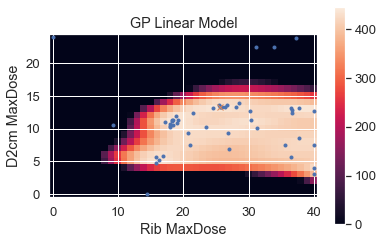

In [102]:
d2cm_linquad = [row[0]/100 for row in bayes_linquad.opt_result.x_iters]
rib_linquad = [row[1]/100 for row in bayes_linquad.opt_result.x_iters]
Z_linquad_gp = np.zeros_like(Z_flag)
k = 0
for ii in range(len(d2cm)):
    for jj in range(len(rib)):
        Z_linquad_gp[jj, ii] = -bayes_linquad.opt_result.models[-1].predict(np.array([d2cm[ii]/2400,rib[jj]/4000]).reshape(1, -1))[0]
plt.imshow(Z_linquad_gp.T, origin='lower')
plt.plot(rib_linquad, d2cm_linquad, '.')
plt.plot(bayes_linquad.opt_result.x[1]/100, bayes_linquad.opt_result.x[0]/100,'x')
plt.xlabel('Rib MaxDose')
plt.ylabel('D2cm MaxDose')
plt.title('GP Linear Model')
plt.colorbar();
plt.clim([0, np.max(Z_linquad)])

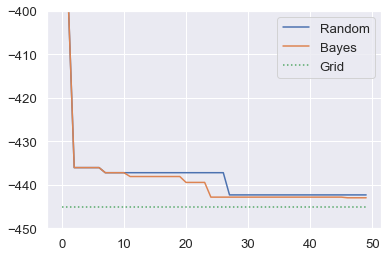

In [115]:
plt.plot(np.minimum.accumulate(-dummy_linquad))
plt.plot(np.minimum.accumulate(bayes_linquad.opt_result.func_vals))
plt.plot([0, 49], [-np.max(Z_linquad), -np.max(Z_linquad)], ':')
plt.ylim([-450, -400])
plt.legend(['Random', 'Bayes', 'Grid'])